# 02. Heat Equation (Intento de fallido de recuperación simbólica)

Intento de recuperación simbólica de EDP. No he conseguido terminarlo. Este ejemplo prueba la librería de resolución de EDPs con la ecuación del calor
$$
\left\{
\begin{array}{l}
\displaystyle \frac{\partial u}{\partial t} = k \partial \frac{\partial^2 u}{\partial x^2} \\
u(x,0)=f(x) \quad u(0,t)=0 \quad u(L,t) = 0
\end{array}
\right.
$$
donde tomaremos $f(x)= 6 \sin \left(\frac{\pi x}{L} \right)$, $L=2$, $k=1$. Además tomaremos $x \in [0,L], t \in [0,1]$.

La solución de la EPD es
$$
u(x,t)=6 \sin \left(\frac{\pi x}{L} \right) e^{-k \left(\frac{\pi}{L}\right)^2 t}
$$

In [34]:
# Iniciamos la clase comparador de MLP vs KAN
from edp_lib.edp_comparator import EDPComparator
import torch
import numpy as np

In [122]:
# Describimos la EDP usando la librería
L=2
k=1

comparator = EDPComparator("2D_new") # Bajo este nombre se guardan los resultados
comparator.configure_variables({ # Configuramos el rango de las variables en el entrenamiento
    "x": (0, L),
    "t": (0, 1)
})
comparator.configure_outputs(["u"]) # Nombramos las funciones que debe aprender el modelo
comparator.configure_pde([lambda u_t, u_xx : u_t - k*u_xx]) # Definimos la edp
comparator.configure_boundaries([ # Definimos las condiciones de frontera
    ({ "x": 0}, lambda t: 0, "u"),
    ({ "x": L}, lambda t: 0, "u"),
    ({ "t": 0}, lambda x: 6*torch.sin((torch.pi*x)/L), "u")
])

# Configuramos la Kan
comparator.configure_kan_settings(grid=10, kan_width=[2,10,1])
comparator.configure_train_settings("kan", steps=100)

# Configuramos el Mlp
comparator.configure_mlp_settings(input_dim=2, output_dim=1, num_hidden_layers=3, hidden_dim=100)
comparator.configure_train_settings("mlp", steps=100)

# Definimos la solución real
comparator.set_real_solution({
    "u": lambda x,t: 6 * np.sin((np.pi * x) / L) * np.exp(-k * (np.pi / L)**2 * t)
})

In [123]:
# Ejecutamos la comparación
comparator.compare("comparation")

description: 100%|████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.64it/s]


Image save as comparation/graphs/2D_new/u/kan.pdf
Image save as comparation/graphs/2D_new/u/mlp.pdf
Image save as comparation/graphs/2D_new/u/real.pdf
Image save as comparation/graphs/2D_new/u/comparation.pdf


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

In [124]:
comparator.get_results()

Total difference between kan model and real solution is 0.0000003076 for function u.
Total difference between mlp model and real solution is 0.0000007867 for function u.


In [125]:
from kan import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [182]:
def create_dataset(train_num=200, test_num=100):

    def generate_sol(num):
        x = torch.linspace(0, L, num)
        t = torch.linspace(0, 1, num)

        pred = comparator.get_funct_pred([x,t])[0]
        pred = torch.from_numpy(pred).float().reshape(-1, 1)

        x, t = torch.meshgrid(x, t, indexing='ij')
        X = torch.stack([x.reshape(-1), t.reshape(-1)], dim=1) 

        return X,pred

    x_train, y_train = generate_sol(train_num)
    x_test, y_test = generate_sol(test_num)

    dataset = {}
    dataset['train_input'] = x_train.to(device)
    dataset['test_input'] = x_test.to(device)
    dataset['train_label'] = y_train.to(device)
    dataset['test_label'] = y_test.to(device)
    return dataset

dataset = create_dataset()

In [196]:
# Entrenamos la red con regularización
model = KAN(width=[2,5,5,1], grid=3, k=3, seed=1222, device=device);
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.01);

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.08e-02 | test_loss: 7.32e-02 | reg: 9.96e+00 | : 100%|█| 50/50 [00:31<00:00,  1.58it

saving model version 0.1


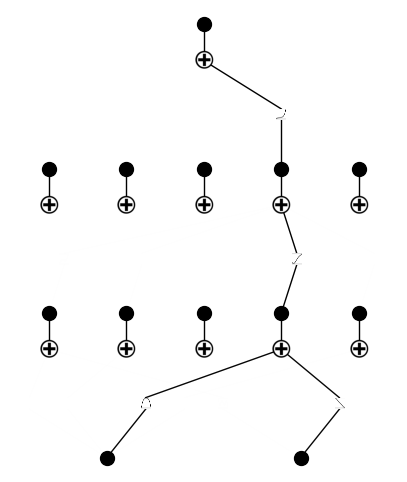

In [198]:
model.plot()

In [199]:
pruned_model = model.prune(node_th=1e-1, edge_th=1e-1)

saving model version 0.2


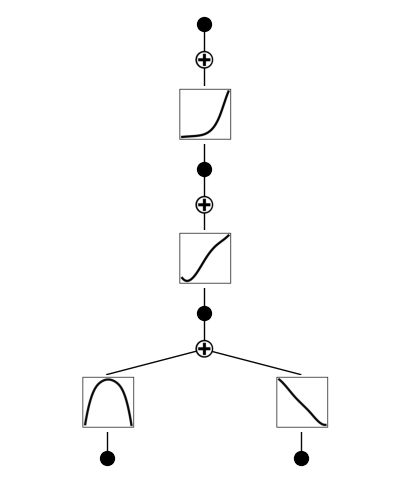

In [200]:
pruned_model.plot()

In [201]:
pruned_model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 4.38e-02 | test_loss: 4.60e-02 | reg: 1.24e+01 | : 100%|█| 50/50 [00:11<00:00,  4.41it

saving model version 0.3


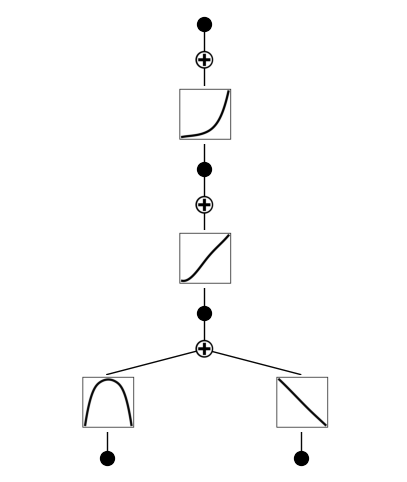

In [203]:
pruned_model.plot()

In [204]:
pruned_model.suggest_symbolic(0,0,0);
pruned_model.suggest_symbolic(0,1,0);
pruned_model.suggest_symbolic(2,0,0);
pruned_model.suggest_symbolic(2,0,0);

  function    fitting r2   r2 loss  complexity  complexity loss  total loss
0        0  0.000000e+00  0.000014           0                0    0.000003
1      x^2  9.619832e-01 -4.716840           2                2    0.656632
2      cos  9.615228e-01 -4.699476           2                2    0.660105
3      sin  9.530565e-01 -4.412624           2                2    0.717475
4        x  9.106981e-09  0.000014           1                1    0.800003
  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        x    0.999660 -11.481157           1                1   -1.496231
1      cos    0.999988 -15.453985           2                2   -1.490797
2      sin    0.999988 -15.453985           2                2   -1.490797
3      x^2    0.999900 -13.148429           2                2   -1.029686
4      exp    0.999897 -13.109149           2                2   -1.021830
   function  fitting r2    r2 loss  complexity  complexity loss  total loss
0     1/x^2    0.9

No sé como ajustar el modelo. Hay demasiados opciones y creo que ninguna buena...

$u(x,t) = e^{ln(sin(x))+t}$